Informação de data

In [ ]:
#Others (1895 - 1923)
dfo = pd.read_csv('catalog_v0.xlsx - other.csv')
dfo['Classe'] = 0
dfo.head()

In [ ]:
# Publishers Weekly’s Bestselling Novels,,,
dfs = pd.read_csv('catalog_v0.xlsx - success.csv')
dfs['Classe'] = 1
dfs.head()

In [ ]:
name = ''.join(dfs["Title"][0].split())
index = dfs["Index"][0]
namesearch = index + '_' + name
print(namesearch)

In [ ]:
concat = pd.concat([dfs, dfo], axis=0)
concat

## Reconhecimento de entidades

In [2]:
import os
import io
import re

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd

In [3]:
import neuralcoref
import spacy 

In [4]:
print('spacy version:', spacy.__version__)
print('neuralcoref version:', neuralcoref.__version__)

spacy version: 2.1.3
neuralcoref version: 4.0.0


In [5]:
def read_file(path):
    try:
        with io.open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except UnicodeDecodeError:
        try:
            with io.open(path, 'r', encoding='latin-1') as f:
                return f.read()
        except UnicodeDecodeError:
            return "Could not decode"
    

In [6]:
folder = "success"

# files sorted by number
files_ordered = sorted(os.listdir(folder), key=lambda name:int(name.split('_')[0]))

# an example file (1)
file = files_ordered[5]

# identifica os livros do dataset succes_others com os files
# if namesearch.lower() in file.lower():
#     print(namesearch, file)
#-----------------------------------------------------------

# name file
path = os.path.join(folder, file)

if os.path.isfile(path):
    content = read_file(path)
    print(f"Content of book ... {file}\n")
    # print(content)

Content of book ... 6_TheMaster_IsraelZangwill_cleared.txt



In [7]:
paragraphs = content.split('\n\n')
# print(paragraphs)

In [8]:
paragraphs_new = []
contents = []
chapters = []
old_idx = 0

for paragraph in paragraphs:
    # print("\n Paragraph: ", paragraph)
    
    lines = paragraph.split('\n')
    # print(lines)
    if re.match('[IVXLCDM\d]+[\.]*', lines[0].upper().strip()):
        if len(contents) == 0:
            contents = [" ".join(line.lower().split()) for line in lines]
            # print("contents", contents)
            
            if len(contents) == 0:
                print("Not found content", id_file)
                exit()
        continue
           
    if paragraph.lower().strip() in contents:
        if old_idx == 0:
            old_idx = len(paragraphs_new)
        else:
            current_idx = len(paragraphs_new)
            chapter = "\n\n".join(paragraphs_new[old_idx:current_idx])
            chapters.append(chapter)
            old_idx = current_idx
        continue
    
    if not re.match('.*[\w]+.*', paragraph):
        continue
    
    paragraphs_new.append(paragraph)
 

    if old_idx != 0:
        chapter = "\n\n".join(paragraphs_new[old_idx:len(paragraphs_new)])
        chapters.append(chapter)
        
print(len(paragraphs), len(paragraphs_new),
      #len(chapters)
     )    

3962 3511


In [9]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

In [10]:
data = []
geral_entities = []

for i, paragraph in enumerate(paragraphs_new[0:15]):
    paragraph = paragraph.replace('\n', ' ')
    paragraph = " ".join(paragraph.split())
    # print('\n', paragraph)****
    
    doc = nlp(paragraph)
    doc_coref = doc._.coref_resolved
    doc_coref = nlp(doc_coref)
    
    entities = []
    for ent in doc_coref.ents:
        if ent.label_ == "PERSON":
            entities.append(ent.text)
    
    if len(entities) > 0:
        len_words = len(paragraph.split())
        geral_entities.extend(entities)
        
        data.append((i, len_words, entities))
        # print('\n', paragraph)
        print(i, len_words, entities)


print("\nGeral Entities:\n", geral_entities)
# print("\nData:\n", data)

1 578 ['Evangeline', 'Gaul', 'Scots', 'McNutt', 'Scots', 'Crash', 'Down', 'Bridges', 'Bridges']
5 79 ['Kidd’s', 'Whoso']
7 14 ['Billy']
8 75 ['Billy', 'Billy', 'Matt']
9 10 ['Matt', 'Billy', 'Billy']
12 11 ['Tis']

Geral Entities:
 ['Evangeline', 'Gaul', 'Scots', 'McNutt', 'Scots', 'Crash', 'Down', 'Bridges', 'Bridges', 'Kidd’s', 'Whoso', 'Billy', 'Billy', 'Billy', 'Matt', 'Matt', 'Billy', 'Billy', 'Tis']


In [11]:
# Conteo de entidades
counter = Counter(geral_entities)
print('\n', counter)


 Counter({'Billy': 5, 'Scots': 2, 'Bridges': 2, 'Matt': 2, 'Evangeline': 1, 'Gaul': 1, 'McNutt': 1, 'Crash': 1, 'Down': 1, 'Kidd’s': 1, 'Whoso': 1, 'Tis': 1})


## Criação de rede de coocorrência

### a. Matriz de coocorrência de personagens

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Lista das entidades (personagens)
entities_list = list(set(geral_entities))

# Inicializa a matriz de coocorrência
cooccurrence_matrix = np.zeros((len(entities_list), len(entities_list)), dtype=int)

# Preenche a matriz de coocorrência
for _, _, paragraph_entities in data:
    for i in range(len(entities_list)):
        if entities_list[i] in paragraph_entities:
            for j in range(i, len(entities_list)):
                if entities_list[j] in paragraph_entities:
                    cooccurrence_matrix[i][j] += 1
                    if i != j:
                        cooccurrence_matrix[j][i] += 1
                               
print("Matriz de Coocorrência:")
print(cooccurrence_matrix)

Matriz de Coocorrência:
[[1 1 1 0 1 1 1 0 0 1 0 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 2]
 [0 0 0 0 0 0 0 0 1 0 1 0]
 [1 1 1 0 1 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 2 0 0 0 3]]


### b. Conjunto de arestas entre as personagens (edge_list)

In [13]:
co_matrix = np.array(cooccurrence_matrix)

# Lista de arestas a ser preenchida
edge_list = []

# Percorre a matriz de coocorrência
for i in range(len(entities_list)):
    for j in range(i + 1, len(entities_list)):
        # Se houver coocorrência, adiciona a aresta
        if co_matrix[i][j] > 0:
            edge = (entities_list[i], entities_list[j])
            # Adiciona peso e cor com base no valor da matriz de coocorrência
            weight = cooccurrence_matrix[i][j]
            edge_list.append((edge[0], edge[1], {'weight': weight}))

# Imprime a lista de arestas
print("Lista de Arestas (edges):")
print(edge_list)

Lista de Arestas (edges):
[('Down', 'McNutt', {'weight': 1}), ('Down', 'Bridges', {'weight': 1}), ('Down', 'Evangeline', {'weight': 1}), ('Down', 'Scots', {'weight': 1}), ('Down', 'Gaul', {'weight': 1}), ('Down', 'Crash', {'weight': 1}), ('McNutt', 'Bridges', {'weight': 1}), ('McNutt', 'Evangeline', {'weight': 1}), ('McNutt', 'Scots', {'weight': 1}), ('McNutt', 'Gaul', {'weight': 1}), ('McNutt', 'Crash', {'weight': 1}), ('Bridges', 'Evangeline', {'weight': 1}), ('Bridges', 'Scots', {'weight': 1}), ('Bridges', 'Gaul', {'weight': 1}), ('Bridges', 'Crash', {'weight': 1}), ('Evangeline', 'Scots', {'weight': 1}), ('Evangeline', 'Gaul', {'weight': 1}), ('Evangeline', 'Crash', {'weight': 1}), ('Scots', 'Gaul', {'weight': 1}), ('Scots', 'Crash', {'weight': 1}), ('Gaul', 'Crash', {'weight': 1}), ('Matt', 'Billy', {'weight': 2}), ('Whoso', 'Kidd’s', {'weight': 1})]


## Visualização de rede

In [14]:
name_list = list(counter.keys())
name_frequency = list(counter.values())
print(name_list)
print(name_frequency)

['Evangeline', 'Gaul', 'Scots', 'McNutt', 'Crash', 'Down', 'Bridges', 'Kidd’s', 'Whoso', 'Billy', 'Matt', 'Tis']
[1, 1, 2, 1, 1, 1, 2, 1, 1, 5, 2, 1]


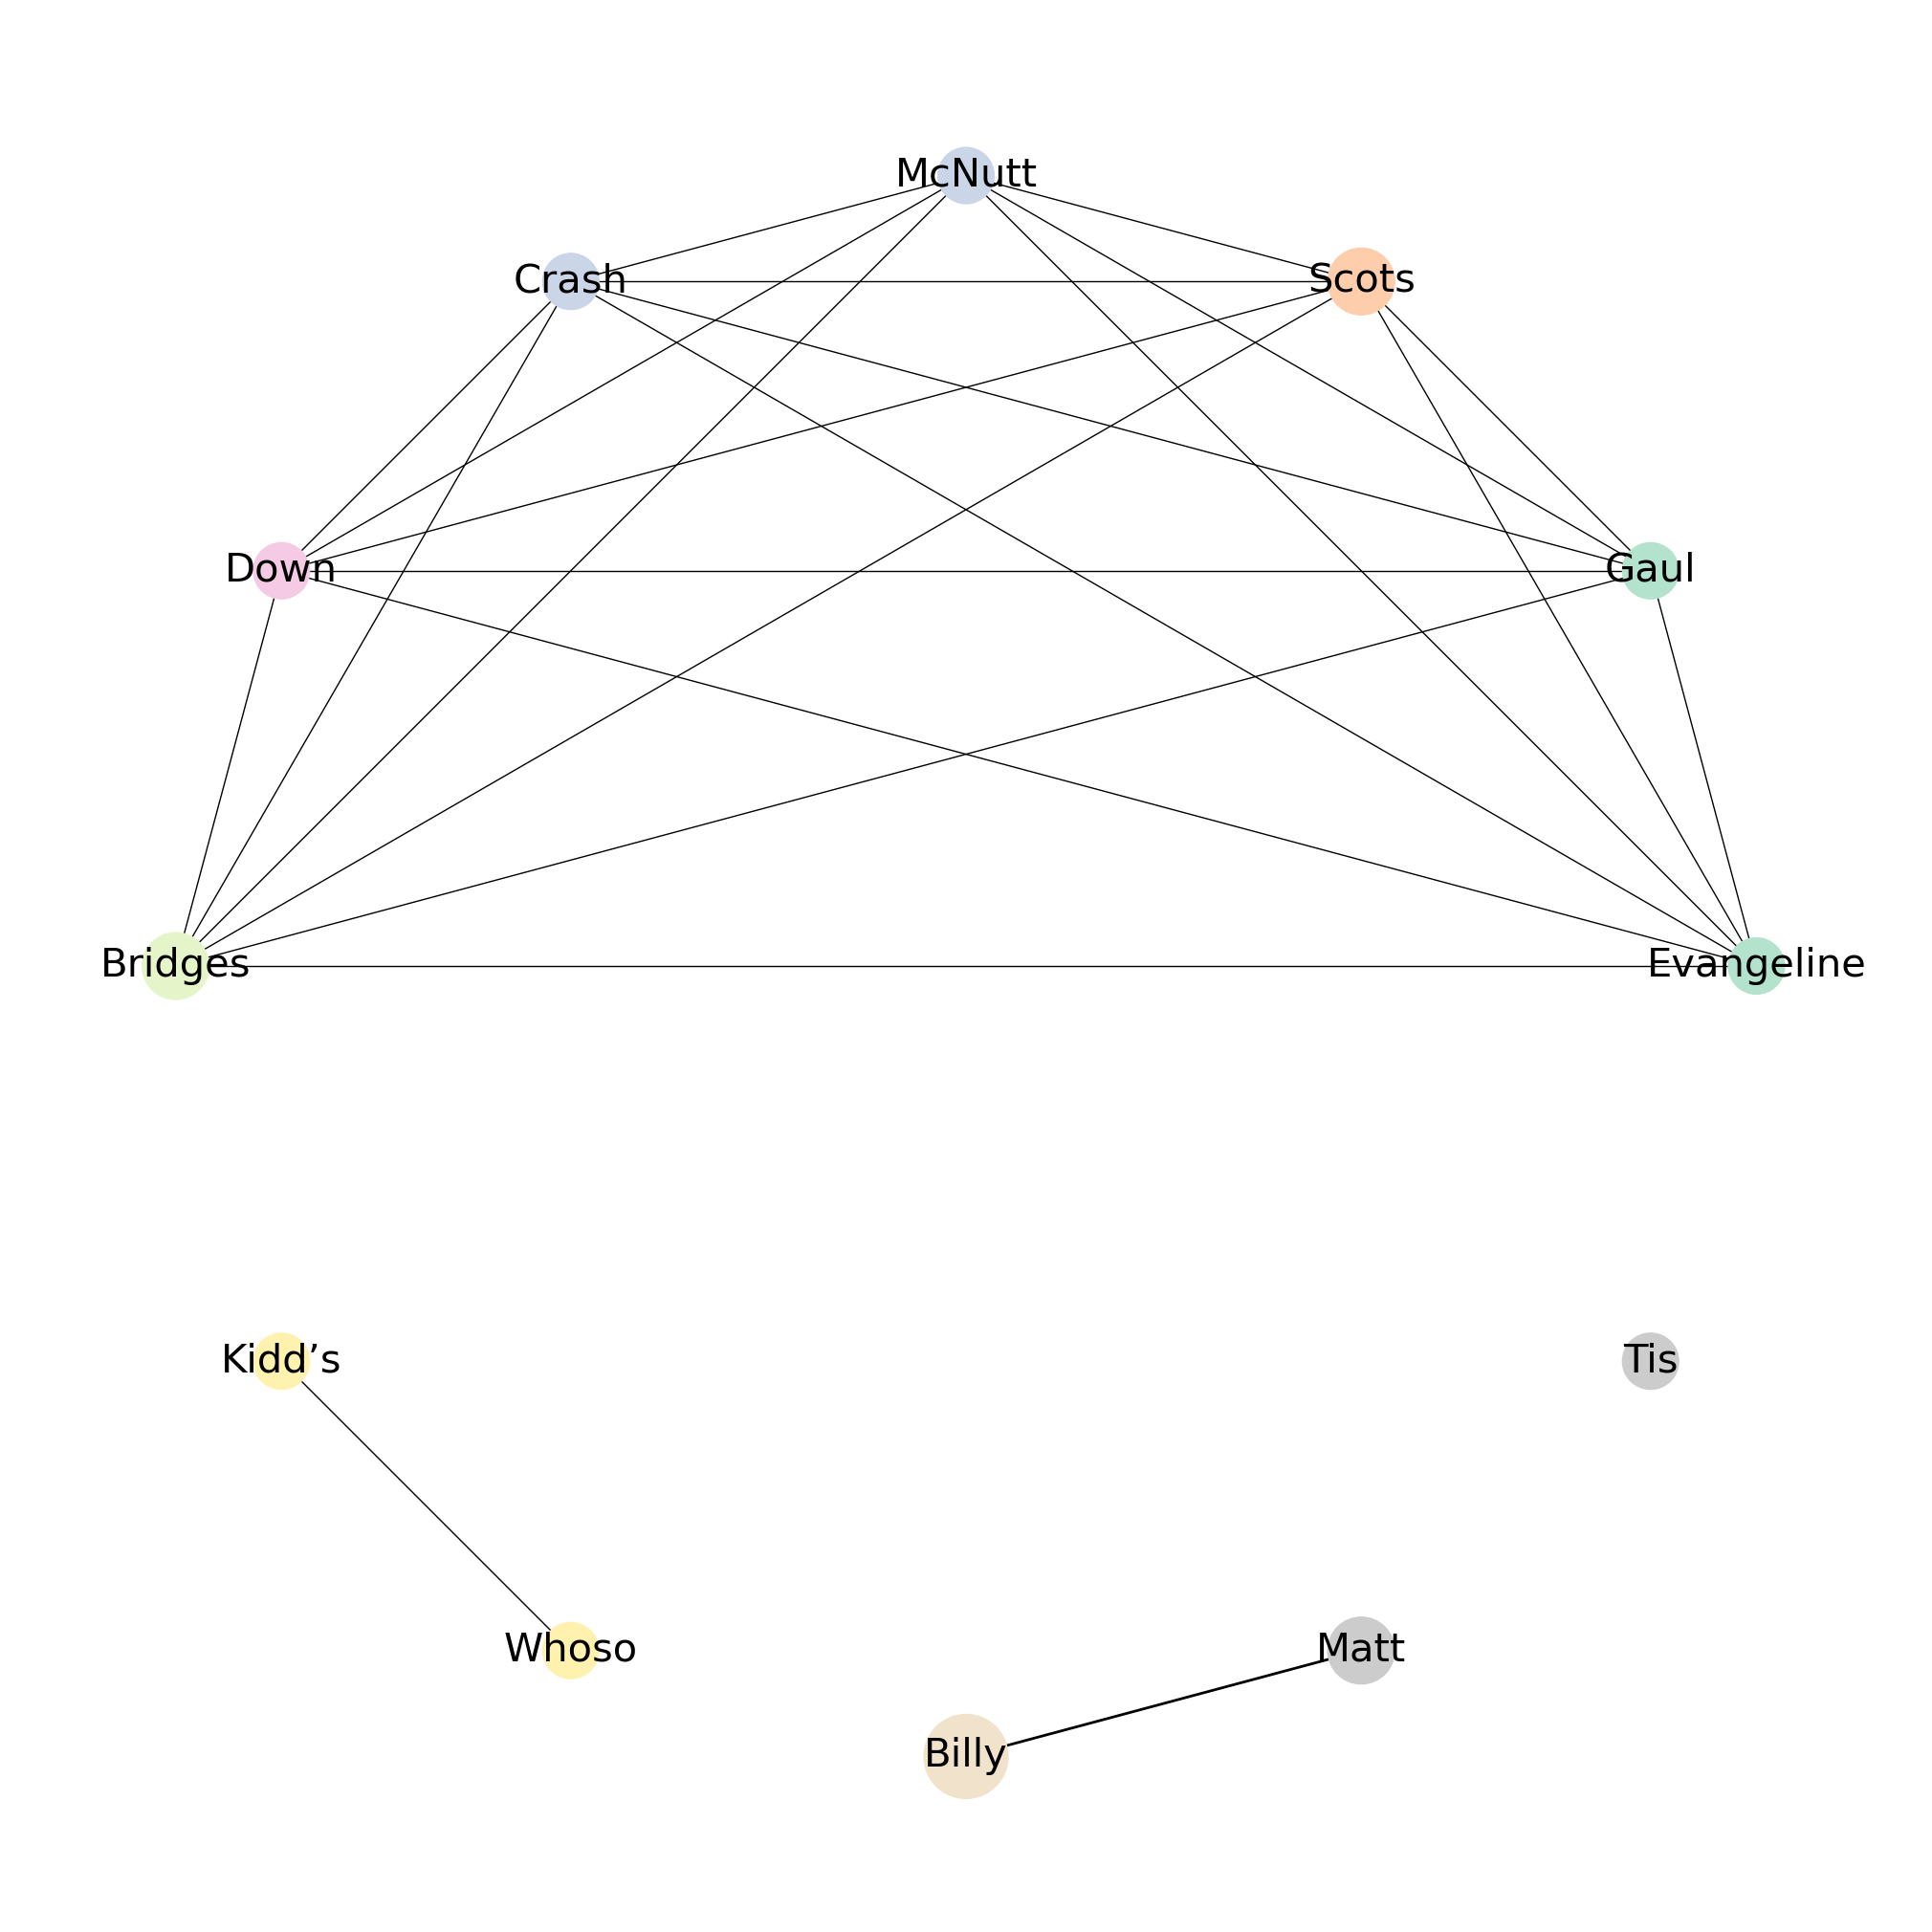

In [32]:
label = {i: i for i in name_list}
edge_list = edge_list # 
normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

plt.figure(figsize=(20, 20))

G = nx.Graph()
G.add_nodes_from(name_list)
G.add_edges_from(edge_list)
pos = nx.circular_layout(G)
edges = G.edges()

# Adicionando pesos às arestas
weights = [G[u][v]['weight'] for u, v in edges]

# Adicionando cores aos nós
node_colors = np.arange(len(name_list))

nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.Pastel2,
        node_size=np.sqrt(normalized_frequency) * 4000, width=weights,
        linewidths=weights, font_size=30, labels=label, with_labels=True)

# Salvar a plotagem como um arquivo PNG
# if path:
#     plt.savefig(path + plt_name)

plt.show()

In [59]:
G.edges.data() # https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html

EdgeDataView([('Evangeline', 'Down', {'weight': 1}), ('Evangeline', 'McNutt', {'weight': 1}), ('Evangeline', 'Bridges', {'weight': 1}), ('Evangeline', 'Scots', {'weight': 1}), ('Evangeline', 'Gaul', {'weight': 1}), ('Evangeline', 'Crash', {'weight': 1}), ('Gaul', 'Down', {'weight': 1}), ('Gaul', 'McNutt', {'weight': 1}), ('Gaul', 'Bridges', {'weight': 1}), ('Gaul', 'Scots', {'weight': 1}), ('Gaul', 'Crash', {'weight': 1}), ('Scots', 'Down', {'weight': 1}), ('Scots', 'McNutt', {'weight': 1}), ('Scots', 'Bridges', {'weight': 1}), ('Scots', 'Crash', {'weight': 1}), ('McNutt', 'Down', {'weight': 1}), ('McNutt', 'Bridges', {'weight': 1}), ('McNutt', 'Crash', {'weight': 1}), ('Crash', 'Down', {'weight': 1}), ('Crash', 'Bridges', {'weight': 1}), ('Down', 'Bridges', {'weight': 1}), ('Kidd’s', 'Whoso', {'weight': 1}), ('Billy', 'Matt', {'weight': 2})])

## Vectorização das medidas de centralidade de rede

### Cálculo das medidas de centralidade

In [81]:
# medidas sem peso -- modificar variables

medidas = [] # Para armazenar as médias das medidas

# Grau médio
grau_medio = np.mean(list(dict(G.degree()).values()))
medidas.append(grau_medio)

# Métricas de centralidade

# Centralidade de grau médio
centrality = np.mean(list(nx.degree_centrality(G).values()))
medidas.append(centrality)

# Centralidade de intermediação média
betweenness = np.mean(list(nx.betweenness_centrality(G).values()))  
medidas.append(betweenness)

# Coeficiente de aglomeração médio
clustering_coefficient = np.mean(list(nx.clustering(G).values()))
medidas.append(clustering_coefficient)                      

# Centralidade de proximidade média
closeness = np.mean(list(nx.closeness_centrality(G).values()))  
medidas.append(closeness)

# Centralidade de vetor próprio médio ****
eigenvector_centrality = np.mean(list(nx.eigenvector_centrality(G).values()))
medidas.append(eigenvector_centrality)

# Centralidade de autovetor médio ****
katz_centrality = np.mean(list(nx.katz_centrality(G).values()))
medidas.append(katz_centrality)

# Imprimir as medidas médias
print("Medidas de Rede:")
for i, medida in enumerate(medidas):
    print(f"Medida {i+1}: {medida}")

Medidas de Rede:
Medida 1: 3.8333333333333335
Medida 2: 0.34848484848484845
Medida 3: 0.0
Medida 4: 0.5833333333333334
Medida 5: 0.34848484848484845
Medida 6: 0.22047940642911454
Medida 7: 0.27124978821449663


In [82]:
# medidas com peso
medidasp = [] # Para armazenar as médias das medidas

# Grau médio ***
grau_medio = np.mean(list(dict(G.degree()).values()))
medidasp.append(grau_medio)

# Força media
forca_media = np.mean([G.degree(node, weight='weight') for node in G.nodes()])
medidasp.append(forca_media)

# Métricas de centralidade

# Centralidade de intermediação média
betweenness = np.mean(list(nx.betweenness_centrality(G, weight='weight').values()))  
medidasp.append(betweenness)

# Coeficiente de aglomeração médio
clustering_coefficient = np.mean(list(nx.clustering(G, weight='weight').values()))
medidasp.append(clustering_coefficient)       

# Centralidade de proximidade ponderada pelos pesos
weighted_closeness = np.mean(list(nx.closeness_centrality(G, distance="weight").values())) 
medidasp.append(weighted_closeness)

# Centralidade de vetor próprio médio
eigenvector_centrality = np.mean(list(nx.eigenvector_centrality(G, weight='weight').values()))
medidasp.append(eigenvector_centrality)

# Centralidade de autovetor médio
katz_centrality = np.mean(list(nx.katz_centrality(G, weight='weight').values()))
medidasp.append(katz_centrality)
                          
# Assortatividade
assortatividade = nx.degree_assortativity_coefficient(G, weight='weight')
medidasp.append(assortatividade)

# Imprimir as medidas médias
print("Medidas de Rede:")
for i, medida in enumerate(medidasp):
    print(f"Medida {i+1}: {medida}")

Medidas de Rede:
Medida 1: 3.8333333333333335
Medida 2: 4.0
Medida 3: 0.0
Medida 4: 0.29166666666666663
Medida 5: 0.3409090909090909
Medida 6: 0.22047972168952953
Medida 7: 0.27273956080141265
Medida 8: 0.9999999999999978


## Classificação

In [83]:
medidasp # medidas de rede com peso do livro x

[3.8333333333333335,
 4.0,
 0.0,
 0.29166666666666663,
 0.3409090909090909,
 0.22047972168952953,
 0.27273956080141265,
 0.9999999999999978]

### Exemplo

In [92]:
num_vetores = 100
matriz_vetores = np.zeros((num_vetores, len(medidasp)))

# Gerar os vetores aleatórios parecidos com o padrão
for i in range(num_vetores):
    # Adicionando ruído aleatório aos elementos do padrão
    vetor_aleatorio = medidasp + np.random.normal(0, 0.1, len(medidasp))
    matriz_vetores[i] = vetor_aleatorio

# Visualizar a matriz de vetores gerada
print("Matriz de Vetores:")
print(matriz_vetores)

Matriz de Vetores:
[[ 3.70829581e+00  4.02680223e+00  2.64396389e-02  3.73218637e-01
   8.31956357e-02  2.84223125e-01  3.74601324e-01  9.10414251e-01]
 [ 3.62168345e+00  3.78874049e+00 -2.15814992e-02  3.77091284e-01
   3.91636819e-01  3.09152239e-01  2.81888357e-01  1.05759381e+00]
 [ 3.86600520e+00  4.02476629e+00  5.05979065e-02  1.83800815e-01
   3.13049700e-01  1.40598345e-01  3.37773215e-01  1.15548887e+00]
 [ 3.79856890e+00  4.11674851e+00 -2.89153741e-02  2.68153010e-01
   3.00462792e-01  2.05717720e-01  2.45654811e-01  1.12663541e+00]
 [ 3.86435561e+00  4.03074093e+00  7.94901440e-03  2.15171947e-01
   2.39331913e-01  1.67642230e-01  2.58386529e-01  1.09335950e+00]
 [ 3.72556776e+00  4.05672281e+00  6.93062190e-02  1.30369799e-01
   3.97453821e-01  1.91338440e-01  1.46347203e-01  1.13449589e+00]
 [ 4.00775008e+00  3.98675286e+00 -8.14530802e-02  5.43940558e-01
   2.66371360e-01  8.06669215e-02  2.44838773e-01  8.78210949e-01]
 [ 3.81416968e+00  3.87449509e+00  4.16662480e-03 

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# dados
X = matriz_vetores
y = np.random.randint(2, size=100) # classes de sucesso
print("classes de sucesso:", y)

# Separar em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do modelo (usando KNN neste exemplo)
knn = KNeighborsClassifier(n_neighbors=5)  # K=5 para o exemplo, ajuste conforme necessário
knn.fit(X_train, y_train)

# Previsão das classes para o conjunto de teste
y_pred = knn.predict(X_test)

classes de sucesso: [1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1]


Acurácia: É a proporção de exemplos classificados corretamente, ou seja, a relação entre o número de previsões corretas e o número total de exemplos.
    
Relatório de Classificação:
        É uma tabela que fornece métricas de avaliação para cada classe no problema de classificação.

Precision:
    A precisão é a proporção de exemplos positivos verdadeiros em relação a todos os exemplos classificados como positivos. É calculada como: precision = TP / (TP + FP), onde TP é o número de verdadeiros positivos e FP é o número de falsos positivos.

Recall:
    O recall é a proporção de exemplos positivos verdadeiros em relação a todos os exemplos que são realmente positivos. É calculado como: recall = TP / (TP + FN), onde TP é o número de verdadeiros positivos e FN é o número de falsos negativos.

F1-Score:
    O F1-score é a média harmônica da precisão e do recall. Fornece um equilíbrio entre precisão e recall. É calculado como: F1-score = 2 * (precision * recall) / (precision + recall).

Support:
    É o número de ocorrências reais da classe no conjunto de dados de teste.

Macro Avg (Média Macro):
    É a média não ponderada das métricas (precision, recall, F1-score) para todas as classes.

Weighted Avg (Média Ponderada):
    É a média ponderada das métricas (precision, recall, F1-score) para todas as classes, onde as ponderações são dadas pelo suporte de cada classe.

In [96]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

# precisão, recall, F1-score e matriz de confusão.
report = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", report)


Acurácia: 0.45
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.42      0.56      0.48         9

    accuracy                           0.45        20
   macro avg       0.46      0.46      0.45        20
weighted avg       0.46      0.45      0.45        20

